Multisite Author Sampling
===

Samples multiple author sites.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm, tqdm_notebook
import random
import pickle
import json

from datetime import datetime
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [3]:
# read feathered user author info dataframe
user_metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
user_info_filepath = os.path.join(user_metadata_dir, 'user_metadata.feather')
user_info_df = pd.read_feather(user_info_filepath)

# convert list datatypes from strings into actual lists
for col in user_info_df.columns:
    if "_list" in col:
        user_info_df[col] = [eval(list_string) for list_string in user_info_df[col]]

len(user_info_df)

667573

In [4]:
user_info_df.head()

,is_site_valid_list,is_user_valid,site_first_created_update_list,site_first_index_update_list,site_id_list,site_last_created_update_list,site_last_index_update_list,site_total_update_count_list,site_update_count_list,total_sites,total_updates,user_id
0,[True],True,[1103856900000],[0],[1],[1261008420000],[186],[187],[187],1,187,1
1,[True],True,[1117053060000],[0],[2],[1180149600000],[28],[29],[29],1,29,2
2,[False],False,[1147748940000],[1],[4],[1147748940000],[1],[1],[1],1,1,4
3,[True],True,[1112730300000],[0],[6],[1372436275000],[16],[17],[17],1,17,6
4,[True],True,[1116042900000],[0],[10],[1117635660000],[14],[15],[15],1,15,12


In [5]:
# load the list of valid users
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_user_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_user_ids.txt"), 'r') as infile:
    for line in infile:
        user_id = line.strip()
        if user_id == "":
            continue
        else:
            valid_user_ids.add(int(user_id))
len(valid_user_ids)

362370

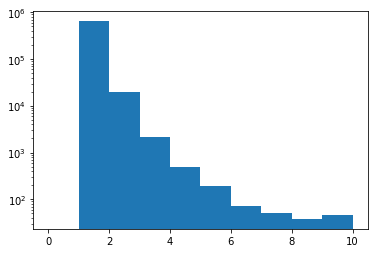

In [10]:
plt.hist(user_info_df.total_sites, log=True, range=(0, 10))
plt.show()

In [11]:
# Valid users are 54.3% of authors
df = user_info_df[user_info_df.user_id.isin(valid_user_ids)]
len(df), len(df) / len(user_info_df)

(362370, 0.5428170402338022)

In [12]:
# less than 1% of valid users are authors on between 3 and 10 sites
site_min = 3
site_max = 10
subset_df = df[(df.total_sites >= site_min)&(df.total_sites <= site_max)]
len(subset_df), len(subset_df) / len(df)

(2263, 0.006244998206253277)

In [13]:
sample = subset_df.sample(n=10)
sample

,is_site_valid_list,is_user_valid,site_first_created_update_list,site_first_index_update_list,site_id_list,site_last_created_update_list,site_last_index_update_list,site_total_update_count_list,site_update_count_list,total_sites,total_updates,user_id
500115,"[True, True, True]",True,"[1449691796000, 1451496926000, 1452626224000]","[0, 0, 0]","[1080667, 1085331, 1088946]","[1449691796000, 1451496926000, 1452626224000]","[0, 0, 0]","[1, 1, 1]","[1, 1, 1]",3,3,32188964
94801,"[True, True, True]",True,"[1251150960000, 1443903765000, 1497123825000]","[0, 0, 0]","[140415, 1061544, 1229820]","[1255005540000, 1451307651000, 1497123825000]","[10, 27, 0]","[11, 36, 1]","[11, 12, 1]",3,24,5209941
213853,"[True, True, True]",True,"[1328385060000, 1463532986000, 1502977824000]","[0, 0, 0]","[475882, 1131399, 1243286]","[1331456746000, 1539786785000, 1547705828000]","[5, 6, 5]","[6, 7, 5]","[4, 7, 5]",3,16,11453234
502416,"[True, True, True]",True,"[1451107850000, 1451733509000, 1454392263000]","[0, 0, 0]","[1084316, 1086012, 1094730]","[1451107850000, 1451733509000, 1454413929000]","[0, 0, 1]","[1, 1, 2]","[1, 1, 2]",3,4,32270900
301508,"[True, True, True]",True,"[1381959920000, 1427483800000, 1428083696000]","[0, 70, 1]","[838191, 994007, 1010647]","[1382149650000, 1427573535000, 1428083696000]","[11, 72, 1]","[12, 106, 10]","[3, 3, 1]",3,7,7793756
171383,"[True, True, True]",True,"[1399990390000, 1314234240000, 1385951910000]","[5, 0, 0]","[317088, 384524, 848160]","[1399993730000, 1417226670000, 1393270255000]","[7, 92, 6]","[5, 93, 7]","[2, 93, 7]",3,102,14512888
357703,"[True, True, True, True, True, True, True]",True,"[1413393002000, 1458048014000, 1501993481000, ...","[0, 0, 0, 0, 0, 0, 0]","[918484, 1106131, 1241265, 1241641, 1245343, 1...","[1413723977000, 1458098498000, 1501993481000, ...","[3, 1, 0, 5, 0, 1, 0]","[4, 2, 1, 6, 1, 2, 1]","[4, 2, 1, 6, 1, 2, 1]",7,17,29659793
102223,"[True, True, True]",True,"[1256151780000, 1280504220000, 1387656143000]","[0, 0, 0]","[150976, 202830, 852470]","[1259046900000, 1303278720000, 1389239472000]","[26, 38, 3]","[27, 39, 4]","[27, 39, 4]",3,70,2336149
129486,"[True, True, True]",True,"[1275881880000, 1275884820000, 1276281720000]","[0, 0, 0]","[194111, 194161, 194922]","[1483511998000, 1349883180000, 1456509723000]","[119, 101, 58]","[118, 99, 59]","[118, 99, 59]",3,276,1770976
516917,"[True, True, True]",True,"[1458130692000, 1458478393000, 1458546184000]","[0, 0, 0]","[1106427, 1107585, 1107862]","[1458130692000, 1458478393000, 1458546184000]","[0, 0, 0]","[1, 1, 1]","[1, 1, 1]",3,3,32789852


In [10]:
sample.user_id

131157     4647459
203808    17921194
484037    31761432
465550    31264325
516190    32764680
427103    30457719
293669     6588887
124831     8892496
67813      2278718
510188    32538830
Name: user_id, dtype: int64

In [12]:
for user_id in sample.user_id:
    url = f"https://127.0.0.1:5000/author/userId/{user_id}"
    print(url)

https://127.0.0.1:5000/author/userId/4647459
https://127.0.0.1:5000/author/userId/17921194
https://127.0.0.1:5000/author/userId/31761432
https://127.0.0.1:5000/author/userId/31264325
https://127.0.0.1:5000/author/userId/32764680
https://127.0.0.1:5000/author/userId/30457719
https://127.0.0.1:5000/author/userId/6588887
https://127.0.0.1:5000/author/userId/8892496
https://127.0.0.1:5000/author/userId/2278718
https://127.0.0.1:5000/author/userId/32538830


### Generate sample of users for annotation

In [6]:
x500_list = ['levon003', 'ghosh100', 'eriks074', 'dow00017']
for x500 in x500_list:
    output_dir = os.path.join(
        "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/",
        x500,
        "user"
    )
    os.makedirs(output_dir, exist_ok=True)

In [7]:
def write_user_id_list_to_file(filename, list_name, user_id_list, x500_list):
    output_filepaths = []
    for x500 in x500_list:
        output_dir = os.path.join(
            "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/",
            x500,
            "user"
        )
        os.makedirs(output_dir, exist_ok=True)
        output_filepath = os.path.join(output_dir, filename)
        with open(output_filepath, 'w') as outfile:
            outfile.write(f"{list_name}\n")
            for user_id in user_id_list:
                outfile.write(f"{user_id}\n")
        output_filepaths.append(output_filepath)
    return output_filepaths

In [13]:
initial_user_set = [
     4647459,
    17921194,
    31761432,
    31264325,
    32764680,
    30457719,
     6588887,
     8892496,
     2278718,
    32538830]

write_user_id_list_to_file("initial_multiuser_set_201909.txt", 
                           "0: Initial set of authors with 3-10 sites - Sept 19, 2019",
                           initial_user_set,
                           x500_list)

['/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/levon003/user/initial_multiuser_set_201909.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/ghosh100/user/initial_multiuser_set_201909.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/eriks074/user/initial_multiuser_set_201909.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/dow00017/user/initial_multiuser_set_201909.txt']

### Identify set of extreme multi-author users


In [21]:
subset_df = df.sort_values(by='total_sites', ascending=False).head(n=20)
len(subset_df)

20

In [22]:
subset_df[['user_id', 'total_sites']]

,user_id,total_sites
465305,30935592,138
516030,32758031,109
197235,17068520,86
516027,32757690,83
517306,32802909,57
519804,32362645,52
2953,118344,37
517307,32796916,35
516025,32757739,34
521412,32937522,32


In [16]:
write_user_id_list_to_file("most_sites_multiauthor_set_201909.txt", 
                           "1: Multi-authors with the most sites (descending order) - Sept 24, 2019",
                           subset_df.user_id,
                           x500_list)

['/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/levon003/user/most_sites_multiauthor_set_201909.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/ghosh100/user/most_sites_multiauthor_set_201909.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/eriks074/user/most_sites_multiauthor_set_201909.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/dow00017/user/most_sites_multiauthor_set_201909.txt']

In [23]:
is_largest_site_active = df.site_total_update_count_list.apply(lambda l: np.max(l) >= 20)
subset_df = df[is_largest_site_active].sort_values(by='total_sites', ascending=False).head(n=20)
subset_df[['user_id', 'total_sites', 'site_total_update_count_list', 'site_update_count_list']]

,user_id,total_sites,site_total_update_count_list,site_update_count_list
516027,32757690,83,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
516025,32757739,34,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
119877,7393709,31,"[73, 3, 5, 1, 4, 3, 1, 2, 2, 2, 1, 1, 2, 1, 6,...","[20, 3, 5, 1, 4, 3, 1, 2, 2, 2, 1, 1, 2, 1, 1,..."
471147,31477721,28,"[21, 78, 68, 23, 2, 11, 15, 2, 2, 3, 2, 1, 1, ...","[21, 78, 68, 23, 2, 11, 15, 2, 2, 3, 2, 1, 1, ..."
319764,28132146,25,"[9, 6, 17, 1, 56, 14, 11, 7, 1, 3, 8, 3, 3, 2,...","[9, 6, 17, 1, 56, 14, 11, 7, 1, 3, 8, 3, 3, 2,..."
256295,25036137,20,"[21, 4, 61, 511, 1, 1439, 211, 3, 1, 18, 8, 1,...","[8, 3, 61, 508, 1, 1437, 211, 3, 1, 18, 7, 1, ..."
488853,31879875,20,"[14, 69, 15, 12, 2, 2, 4, 2, 1, 1, 1, 3, 38, 1...","[14, 69, 15, 12, 2, 2, 4, 2, 1, 1, 1, 3, 38, 1..."
485336,31799168,18,"[64, 28, 7, 12, 14, 1, 3, 3, 2, 1, 1, 2, 3, 51...","[64, 28, 7, 12, 14, 1, 3, 3, 2, 1, 1, 2, 3, 51..."
507046,32428328,17,"[14, 22, 15, 15, 21, 21, 10, 20, 21, 22, 21, 1...","[14, 22, 15, 15, 21, 21, 10, 20, 21, 22, 21, 1..."
397,81,16,"[28, 4, 4, 1, 3, 1, 40, 6, 3, 3, 2, 3, 36, 1, ...","[23, 4, 4, 1, 3, 1, 39, 6, 3, 3, 2, 3, 36, 1, ..."


In [20]:
write_user_id_list_to_file("most_sites_multiauthor_set2_201909.txt", 
                           "2: Multi-authors with the most sites & 1+ active site w/ 20+ updates - Sept 24, 2019",
                           subset_df.user_id,
                           x500_list)

['/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/levon003/user/most_sites_multiauthor_set2_201909.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/ghosh100/user/most_sites_multiauthor_set2_201909.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/eriks074/user/most_sites_multiauthor_set2_201909.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/dow00017/user/most_sites_multiauthor_set2_201909.txt']

## Cross interactions with site authorship

Goal: Generate a list of the most-active authors that also do at least some interaction with other authors.


In [8]:
s = datetime.now()
user_metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
hdf5_store_filepath = os.path.join(user_metadata_dir, "interaction_metadata.h5")
store = pd.HDFStore(hdf5_store_filepath)
try:
    user_interaction_df = store.get('user_ints_df')
finally:
    store.close()
print(datetime.now() - s)
print(len(user_interaction_df))

0:01:12.983044
28388948


In [21]:
user_interaction_df.sample(5)

,user_id,site_id,int_type,created_at,updated_at,journal_oid,site_index,is_nontrivial,is_self_interaction
20306662,361392,432232,journal,1342997100000,1342998024000,51be4c296ca004306c003b01,100.0,True,True
7797522,30000326,947408,amps,1433688058000,1433688058000,557457faca16b4ce401e02ef,29.0,True,False
8368200,877781,1199393,amps,1495250456000,1495250456000,591fb6188b5cd3be6a3096f0,103.0,True,False
12020675,1312832,30092,journal,1192740600000,1192740600000,51bdfb916ca004ac6600e9e9,38.0,True,True
27468848,36510993,1234781,journal,1500229656000,1500229656000,596bb018af3d79a675a67e6f,5.0,True,True


In [13]:
# interaction counts by type for all self-interactions
Counter(user_interaction_df[user_interaction_df.is_self_interaction].int_type).most_common()

[('journal', 17893390),
 ('guestbook', 651584),
 ('amps', 498975),
 ('comment', 212654)]

In [9]:
for int_type in set(user_interaction_df.int_type):
    created_at = user_interaction_df[(user_interaction_df.int_type==int_type)&(user_interaction_df.created_at > 100000)].created_at
    first_int = datetime.utcfromtimestamp(np.min(created_at) / 1000)
    last_int = datetime.utcfromtimestamp(np.max(created_at) / 1000)
    print(f"{int_type} {str(first_int)} {last_int}")
                                           

journal 1970-01-01 00:04:00 2032-01-01 05:15:00
comment 2013-07-27 18:07:37 2019-02-10 01:39:14
guestbook 2005-06-01 06:50:30 2016-06-01 21:07:43
amps 2003-08-15 06:20:00 2019-02-10 18:49:22


In [14]:
# interaction counts by type for all non-self-interactions
Counter(user_interaction_df[~user_interaction_df.is_self_interaction].int_type).most_common()

[('guestbook', 5212720), ('amps', 3037844), ('comment', 881781)]

In [15]:
users_with_nonzero_interauthor_interaction = set(user_interaction_df[~user_interaction_df.is_self_interaction].user_id)
len(users_with_nonzero_interauthor_interaction)

208820

In [22]:
subset_df = df[df.user_id.isin(users_with_nonzero_interauthor_interaction)]
is_largest_site_active = subset_df.site_total_update_count_list.apply(lambda l: np.max(l) >= 20)
subset_df = subset_df[is_largest_site_active].sort_values(by='total_sites', ascending=False).head(n=20)
subset_df[['user_id', 'total_sites', 'site_total_update_count_list', 'site_update_count_list']]

,user_id,total_sites,site_total_update_count_list,site_update_count_list
119877,7393709,31,"[73, 3, 5, 1, 4, 3, 1, 2, 2, 2, 1, 1, 2, 1, 6,...","[20, 3, 5, 1, 4, 3, 1, 2, 2, 2, 1, 1, 2, 1, 1,..."
256295,25036137,20,"[21, 4, 61, 511, 1, 1439, 211, 3, 1, 18, 8, 1,...","[8, 3, 61, 508, 1, 1437, 211, 3, 1, 18, 7, 1, ..."
397,81,16,"[28, 4, 4, 1, 3, 1, 40, 6, 3, 3, 2, 3, 36, 1, ...","[23, 4, 4, 1, 3, 1, 39, 6, 3, 3, 2, 3, 36, 1, ..."
22,46,14,"[54, 1, 1, 4, 2, 51, 190, 15, 1, 5, 1, 12, 6, 1]","[54, 1, 1, 1, 1, 2, 1, 1, 1, 5, 1, 12, 1, 1]"
119876,8192483,14,"[73, 1, 9, 1, 10, 2, 4, 1, 15, 2, 1, 1, 1, 1]","[53, 1, 9, 1, 10, 2, 4, 1, 15, 2, 1, 1, 1, 1]"
9646,551312,11,"[31, 18, 4, 3, 2, 13, 23, 23, 24, 34, 17]","[31, 18, 4, 3, 2, 13, 3, 10, 9, 1, 17]"
204946,18061940,11,"[1, 132, 1, 54, 17, 8, 125, 144, 101, 215, 37]","[1, 132, 1, 54, 17, 8, 125, 144, 101, 215, 37]"
79145,5450473,10,"[8, 74, 4, 6, 4, 4, 13, 5, 15, 1]","[8, 74, 4, 6, 4, 4, 13, 5, 15, 1]"
158685,4350866,10,"[63, 19, 37, 6, 1, 4, 14, 61, 12, 3]","[62, 19, 29, 1, 1, 4, 14, 2, 12, 1]"
36082,2396153,10,"[390, 178, 62, 595, 329, 403, 1500, 1, 6, 8]","[390, 178, 62, 595, 329, 403, 713, 1, 6, 8]"


In [21]:
write_user_id_list_to_file("most_sites_multiauthor_set3_201909.txt", 
                           "3: Multi-authors by site count with 1+ active site w/ 20+ updates & 1+ inter-author interaction - Sept 30, 2019",
                           subset_df.user_id,
                           x500_list)

['/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/levon003/user/most_sites_multiauthor_set3_201909.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/ghosh100/user/most_sites_multiauthor_set3_201909.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/eriks074/user/most_sites_multiauthor_set3_201909.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/dow00017/user/most_sites_multiauthor_set3_201909.txt']

In [25]:
subset_df = df[df.user_id.isin(users_with_nonzero_interauthor_interaction)]
subset_df = subset_df.sort_values(by='total_sites', ascending=False).head(n=20)
subset_df[['user_id', 'total_sites', 'site_total_update_count_list', 'site_update_count_list']]

,user_id,total_sites,site_total_update_count_list,site_update_count_list
2953,118344,37,"[2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, ...","[2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, ..."
119877,7393709,31,"[73, 3, 5, 1, 4, 3, 1, 2, 2, 2, 1, 1, 2, 1, 6,...","[20, 3, 5, 1, 4, 3, 1, 2, 2, 2, 1, 1, 2, 1, 1,..."
95355,3585182,24,"[6, 2, 5, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[6, 2, 5, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
256295,25036137,20,"[21, 4, 61, 511, 1, 1439, 211, 3, 1, 18, 8, 1,...","[8, 3, 61, 508, 1, 1437, 211, 3, 1, 18, 7, 1, ..."
397,81,16,"[28, 4, 4, 1, 3, 1, 40, 6, 3, 3, 2, 3, 36, 1, ...","[23, 4, 4, 1, 3, 1, 39, 6, 3, 3, 2, 3, 36, 1, ..."
157382,11120759,15,"[2, 1, 1, 2, 2, 1, 1, 7, 8, 2, 1, 2, 3, 1, 1]","[2, 1, 1, 2, 2, 1, 1, 7, 8, 2, 1, 2, 3, 1, 1]"
119876,8192483,14,"[73, 1, 9, 1, 10, 2, 4, 1, 15, 2, 1, 1, 1, 1]","[53, 1, 9, 1, 10, 2, 4, 1, 15, 2, 1, 1, 1, 1]"
22,46,14,"[54, 1, 1, 4, 2, 51, 190, 15, 1, 5, 1, 12, 6, 1]","[54, 1, 1, 1, 1, 2, 1, 1, 1, 5, 1, 12, 1, 1]"
266938,24427889,11,"[2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2]","[2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2]"
9646,551312,11,"[31, 18, 4, 3, 2, 13, 23, 23, 24, 34, 17]","[31, 18, 4, 3, 2, 13, 3, 10, 9, 1, 17]"


In [26]:
write_user_id_list_to_file("most_sites_multiauthor_set4_201909.txt", 
                           "4: Multi-authors by site count with 1+ inter-author interaction - Sept 30, 2019",
                           subset_df.user_id,
                           x500_list)

['/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/levon003/user/most_sites_multiauthor_set4_201909.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/ghosh100/user/most_sites_multiauthor_set4_201909.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/eriks074/user/most_sites_multiauthor_set4_201909.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/dow00017/user/most_sites_multiauthor_set4_201909.txt']

In [18]:
user_interaction_counts = Counter(user_interaction_df[~user_interaction_df.is_self_interaction].user_id)
most_interacting_users = [user_id for user_id, _ in user_interaction_counts.most_common(20)]
subset_df = df[df.user_id.isin(most_interacting_users)]
subset_df[['user_id', 'total_updates', 'total_sites', 'site_total_update_count_list', 'site_update_count_list']]

,user_id,total_updates,total_sites,site_total_update_count_list,site_update_count_list
2636,107444,590,4,"[174, 107, 232, 90]","[174, 94, 232, 90]"
6597,344983,1477,2,"[3192, 8]","[1469, 8]"
11236,653166,1836,1,[2205],[1836]
18370,1141159,383,4,"[205, 146, 21, 22]","[205, 146, 21, 11]"
39423,2453195,458,1,[458],[458]
39532,2121085,727,2,"[1080, 3]","[724, 3]"
41930,2246625,735,6,"[140, 3, 27, 159, 397, 9]","[140, 3, 27, 159, 397, 9]"
54398,3697148,116,1,[116],[116]
69024,3295808,4672,2,"[13540, 184]","[4488, 184]"
72277,4723745,1280,1,[1280],[1280]


In [19]:
write_user_id_list_to_file("most_interactions_author_set5_201910.txt", 
                           "5: Authors by total interaction count - October 01, 2019",
                           most_interacting_users,
                           x500_list)

['/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/levon003/user/most_interactions_author_set5_201910.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/ghosh100/user/most_interactions_author_set5_201910.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/eriks074/user/most_interactions_author_set5_201910.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/dow00017/user/most_interactions_author_set5_201910.txt']

In [29]:
# compute the number of unique sites interacted with by each user
# does not include self-interactions (and thus not journal updates)
interacted_sites_count = user_interaction_df[~user_interaction_df.is_self_interaction].groupby('user_id').apply(lambda group: len(set(group.site_id)))
# interacted_sites_count is a Series where the index is the user_id (the groupby key)
most_interacted_sites_user_list = interacted_sites_count.sort_values(ascending=False)[:20].index.values

In [30]:
# these are the users with the greatest outdegree in the interaction network
subset_df = df[df.user_id.isin(most_interacted_sites_user_list)]
subset_df[['user_id', 'total_updates', 'total_sites', 'site_total_update_count_list', 'site_update_count_list']]

,user_id,total_updates,total_sites,site_total_update_count_list,site_update_count_list
6597,344983,1477,2,"[3192, 8]","[1469, 8]"
10727,618134,1733,1,[1733],[1733]
12402,728698,452,4,"[160, 44, 246, 2]","[160, 44, 246, 2]"
18784,1170478,2005,1,[3148],[2005]
19977,1262629,166,1,[166],[166]
23287,1491198,676,2,"[748, 197]","[502, 174]"
24898,1603960,337,5,"[267, 56, 7, 5, 2]","[267, 56, 7, 5, 2]"
25538,1504535,407,3,"[357, 48, 2]","[357, 48, 2]"
26048,1687700,1039,1,[1039],[1039]
33295,2197208,126,2,"[33, 93]","[33, 93]"


In [31]:
write_user_id_list_to_file("most_interacted_sites_author_set6_201910.txt", 
                           "6: Authors by total unique sites interacted with - October 01, 2019",
                           most_interacted_sites_user_list,
                           x500_list)

['/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/levon003/user/most_interacted_sites_author_set6_201910.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/ghosh100/user/most_interacted_sites_author_set6_201910.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/eriks074/user/most_interacted_sites_author_set6_201910.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/dow00017/user/most_interacted_sites_author_set6_201910.txt']

In [33]:
# identify the set of sites with the greatest indegree, 
# then select the authors who have written 1+ update on those sites
site_indegree_map = defaultdict(int)
for user_id, group in tqdm(user_interaction_df[~user_interaction_df.is_self_interaction].groupby('user_id')):
    for site_id in set(group.site_id):
        site_indegree_map[site_id] += 1

100%|██████████| 208820/208820 [01:21<00:00, 2549.55it/s]


In [39]:
sites_with_highest_indegree = [(site_id, site_indegree_map[site_id]) for site_id in site_indegree_map.keys()]
sites_with_highest_indegree.sort(key=lambda tup: tup[1], reverse=True)
sites_with_highest_indegree = sites_with_highest_indegree[:20]
sites_with_highest_indegree

[(133086, 1667),
 (156877, 959),
 (59067, 775),
 (63710, 714),
 (80404, 656),
 (38730, 602),
 (38667, 568),
 (454315, 554),
 (82912, 548),
 (37177, 509),
 (83093, 485),
 (200618, 483),
 (44879, 472),
 (26118, 468),
 (14314, 460),
 (140252, 386),
 (16276, 378),
 (20664, 368),
 (11262, 364),
 (138276, 361)]

In [46]:
# select authors who have posted at least one update on a site in sites_with_highest_indegree
authors_of_sites_with_highest_indegree = []
for site_id, count in sites_with_highest_indegree:
    user_ids = df[df.site_id_list.apply(lambda site_id_list: site_id in site_id_list)].user_id
    print(site_id, count, len(user_ids))
    authors_of_sites_with_highest_indegree.extend(user_ids)
len(authors_of_sites_with_highest_indegree)

133086 1667 1
156877 959 1
59067 775 1
63710 714 1
80404 656 1
38730 602 1
38667 568 1
454315 554 2
82912 548 1
37177 509 1
83093 485 1
200618 483 1
44879 472 1
26118 468 1
14314 460 1
140252 386 1
16276 378 1
20664 368 1
11262 364 1
138276 361 1


21

In [45]:
write_user_id_list_to_file("most_interacted_sites_author_set7_201910.txt", 
                           "7: Authors of the 20 sites that are most interacted with - October 01, 2019",
                           authors_of_sites_with_highest_indegree,
                           x500_list)

['/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/levon003/user/most_interacted_sites_author_set7_201910.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/ghosh100/user/most_interacted_sites_author_set7_201910.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/eriks074/user/most_interacted_sites_author_set7_201910.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/dow00017/user/most_interacted_sites_author_set7_201910.txt']

In [47]:
# now create a similar set of the most-interacted-with multi-author sites
# we go down the list of most-interacted sites until we hit 20 authors across whatever multiauthor sites
# we've already come across
sites_with_highest_indegree = [(site_id, site_indegree_map[site_id]) for site_id in site_indegree_map.keys()]
sites_with_highest_indegree.sort(key=lambda tup: tup[1], reverse=True)
multiauthor_sites_with_highest_indegree = []
authors_of_multiauthor_sites_with_highest_indegree = []
for site_id, count in sites_with_highest_indegree:
    site_author_ids = df[df.site_id_list.apply(lambda site_id_list: site_id in site_id_list)].user_id
    if len(site_author_ids) > 1:
        # this is a multiauthor site
        multiauthor_sites_with_highest_indegree.append((site_id, count))
        authors_of_multiauthor_sites_with_highest_indegree.extend(site_author_ids)
    if len(authors_of_multiauthor_sites_with_highest_indegree) >= 20:
        break
len(authors_of_multiauthor_sites_with_highest_indegree), len(multiauthor_sites_with_highest_indegree)

(20, 9)

In [48]:
# these sites still have extremely high indegree...
multiauthor_sites_with_highest_indegree

[(454315, 554),
 (21255, 348),
 (44658, 284),
 (265764, 241),
 (28236, 235),
 (440758, 228),
 (45591, 216),
 (840917, 209),
 (188224, 209)]

In [49]:
write_user_id_list_to_file("most_interacted_multiauthor_sites_author_set8_201910.txt", 
                           "8: Authors of the 9 multiauthor sites that are most interacted with - October 01, 2019",
                           authors_of_multiauthor_sites_with_highest_indegree,
                           x500_list)

['/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/levon003/user/most_interacted_multiauthor_sites_author_set8_201910.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/ghosh100/user/most_interacted_multiauthor_sites_author_set8_201910.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/eriks074/user/most_interacted_multiauthor_sites_author_set8_201910.txt',
 '/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/dow00017/user/most_interacted_multiauthor_sites_author_set8_201910.txt']

In [ ]:
# TODO Probably create sets based on indegree, but for each of the three interaction types specifically

## Sites for "crowdsourced" spam annotation


In [9]:
site_metadata_working_dir = "/home/srivbane/shared/caringbridge/data/derived/site_metadata"
s = datetime.now()
site_metadata_filepath = os.path.join(site_metadata_working_dir, "site_metadata.feather")
site_metadata_df = pd.read_feather(site_metadata_filepath)
print(datetime.now() - s)
len(site_metadata_df)

0:00:02.091498


840943

In [10]:
Counter(site_metadata_df.privacy).most_common()

[('medium', 736284), ('high', 73167), ('low', 31492)]

In [11]:
Counter(site_metadata_df.isGoogleable).most_common()

[(None, 581352), ('1', 132204), ('0', 127387)]

In [12]:
Counter(site_metadata_df.isSearchable).most_common()

[('1', 395346), (None, 284203), ('0', 161394)]

In [13]:
Counter(site_metadata_df.isDeleted).most_common()

[(None, 674419), ('1', 165709), ('0', 815)]

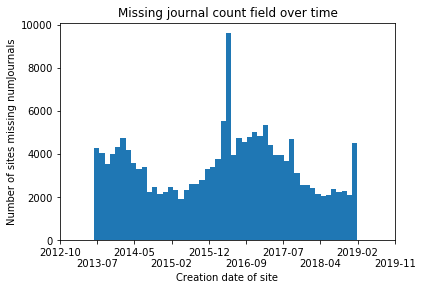

In [39]:
journal_count_missing = site_metadata_df.numJournals == -1

createdAt_missing = site_metadata_df[journal_count_missing].created_at
plt.hist(createdAt_missing / 1000, bins=50)
xticks, _ = plt.xticks()
xticklabels = [datetime.utcfromtimestamp(xtick).strftime('%Y-%m') if i % 2 == 0 else "\n" + datetime.utcfromtimestamp(xtick).strftime('%Y-%m')
               for i, xtick in enumerate(xticks)]
plt.xticks(ticks=xticks, labels=xticklabels)
plt.title("Missing journal count field over time")
plt.ylabel("Number of sites missing numJournals")
plt.xlabel("Creation date of site")
plt.show()

#### Select sites for spam identification according to the following criteria

Filter criteria:
 - Privacy is low or medium
 - isGoogleable is not 0
 - isSearchable is not 0
 - isDeleted is not 1
 - Has author with total (non-self) interactions >= 1 OR has at been interacted with by at least one author
 - Site created pre-June 2016
 - Has 1+ updates authored by user in the sample
 
Sort criteria:
 - Number of unique sites authored by all authoring users of that site
 - Number of total (non-self) interactions (max of site authors)

In [10]:
display(user_info_df.head(1))
display(user_interaction_df.head(1))
display(site_metadata_df.head(1))

,is_site_valid_list,is_user_valid,site_first_created_update_list,site_first_index_update_list,site_id_list,site_last_created_update_list,site_last_index_update_list,site_total_update_count_list,site_update_count_list,total_sites,total_updates,user_id
0,[True],True,[1103856900000],[0],[1],[1261008420000],[186],[187],[187],1,187,1


,user_id,site_id,int_type,created_at,updated_at,journal_oid,site_index,is_nontrivial,is_self_interaction
0,322059,20005,guestbook,1371420989000,1371420989000,,-1.0,True,True


,age,created_at,hasVisitorInvite,healthCondition_category,healthCondition_custom,healthCondition_name,ip,isDeleted,isForSelf,isGoogleable,...,numPhotos,numTasks,numTributes,numVisitorInvites,privacy,publish_date,site_id,title,updated_at,visits
0,adult,1257785950000,None,Surgery/Transplantation,None,Surgery,None,None,None,None,...,3,0,0,-1,medium,0,154247,Pat Collins,1369952505000,50


In [11]:
user_interaction_counts = Counter(user_interaction_df[~user_interaction_df.is_self_interaction].user_id)
user_info_df['nonself_interaction_count'] = user_info_df.user_id.apply(lambda user_id: user_interaction_counts[user_id])

In [12]:
site_interaction_counts = Counter(user_interaction_df[~user_interaction_df.is_self_interaction].site_id)
len(site_interaction_counts)

221168

In [13]:
valid_site_ids = set()

# add all sites with at least one interacting user
user_info_subset = user_info_df[(user_info_df.is_user_valid)&(user_info_df.nonself_interaction_count > 0)]
for site_id_list in user_info_subset.site_id_list:
    for site_id in site_id_list:
        valid_site_ids.add(site_id)

# add all sites that are interacted with
for site_id in site_interaction_counts.keys():
    valid_site_ids.add(site_id)
        
len(valid_site_ids)

286222

In [14]:
july_2016 = 1467331200000
site_subset = site_metadata_df[(site_metadata_df.site_id.isin(valid_site_ids))&(site_metadata_df.created_at < july_2016)]
len(site_subset)

255704

In [15]:
site_subset = site_subset[(site_subset.isDeleted != 1)&(site_subset.privacy != 'high')&(site_subset.isSearchable != 0)&(site_subset.isGoogleable != 0)]
len(site_subset)

247235

In [16]:
site_info_map = defaultdict(list)
def create_info_map(row):
    for site_id in row.site_id_list:
        site_info_map[site_id].append((row.total_sites, row.nonself_interaction_count))
user_info_df.apply(create_info_map, axis=1)
len(site_info_map)

605628

In [17]:
most_total_sites_map = {}
most_nonself_interaction_counts_map = {}
for site_id in site_info_map.keys():
    site_info_list = site_info_map[site_id]
    most_total_sites = np.max([t[0] for t in site_info_list])
    most_nonself_interaction_counts = np.max([t[1] for t in site_info_list])
    most_total_sites_map[site_id] = most_total_sites
    most_nonself_interaction_counts_map[site_id] = most_nonself_interaction_counts

In [18]:
site_subset['most_total_sites'] = site_subset.site_id.apply(lambda site_id: most_total_sites_map[site_id] if site_id in most_total_sites_map else 0)
site_subset['most_nonself_interaction_counts'] = site_subset.site_id.apply(lambda site_id: most_nonself_interaction_counts_map[site_id] if site_id in most_nonself_interaction_counts_map else 0)

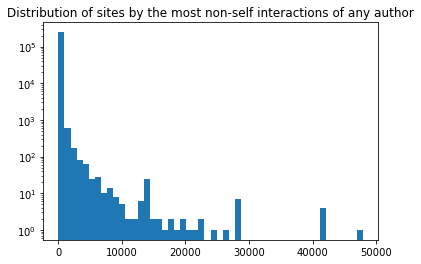

In [19]:
plt.hist(site_subset.most_nonself_interaction_counts, bins=50, log=True)
plt.title("Distribution of sites by the most non-self interactions of any author")
plt.show()

In [20]:
site_subset = site_subset.sort_values(by=['most_total_sites', 'most_nonself_interaction_counts'], ascending=False)
site_subset.head()

,age,created_at,hasVisitorInvite,healthCondition_category,healthCondition_custom,healthCondition_name,ip,isDeleted,isForSelf,isGoogleable,...,numTributes,numVisitorInvites,privacy,publish_date,site_id,title,updated_at,visits,most_total_sites,most_nonself_interaction_counts
206431,teen,1229915767000,1,Neurological Condition,,Brain Damage,None,None,0,1,...,3,-1,medium,0,103602,Jesse Garrett Green,1549840966000,1071905,9824,28391
19103,child,1138239545000,1,Neurological Condition,,Epilepsy/Seizure Disorders,None,None,None,None,...,1,-1,medium,0,9661,PRINCESS ARIEL,1549747158000,121430,9824,26700
56410,adult,1276440412000,1,Infant/Childbirth,,Premature Birth,None,0,0,None,...,10,-1,medium,0,195189,Liz ''Faithful'' Warren,1548991537000,145760,9824,22228
451135,adult,1337911077000,1,Neurological Condition,,Epilepsy/Seizure Disorders,None,None,0,None,...,4,-1,medium,1337911160000,541331,Roxanne's Journey,1371563038000,80490,9824,19464
117873,adult,1200700643000,1,Cardiovascular/Stroke,,Stroke,None,None,None,None,...,0,-1,medium,0,59231,ginacorbin,1479880410000,48100,9824,18403


In [21]:
Counter(site_subset.isSpam)  # two potential spam sites on which a non-spam author was a coauthor or interacted with that spam site...

Counter({None: 247233, '1': 2})

In [57]:
# write out top 1000 site ids to inspect to a text file
selected_sites_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection/human_site_annotation"
with open(os.path.join(selected_sites_dir, "selected_site_ids_201910.txt"), 'w') as outfile:
    for site_id in site_subset.site_id[:1000]:
        outfile.write(str(site_id) + "\n")
print("Finished.")

Finished.


In [22]:
# write out 500 random site ids to inspect to a text file
selected_sites_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection/human_site_annotation"
with open(os.path.join(selected_sites_dir, "random_site_ids_201910.txt"), 'w') as outfile:
    for site_id in site_subset.sample(n=500).site_id:
        outfile.write(str(site_id) + "\n")
print("Finished.")

Finished.
